# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

In [1]:
from numpy.random import seed
seed(1)

from tensorflow.random import set_seed
set_seed(2)

In [2]:
import tensorflow as tf

from tqdm import tqdm_notebook

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [3]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

170508288/170498071 [==============================] - 2s 0us/step
(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

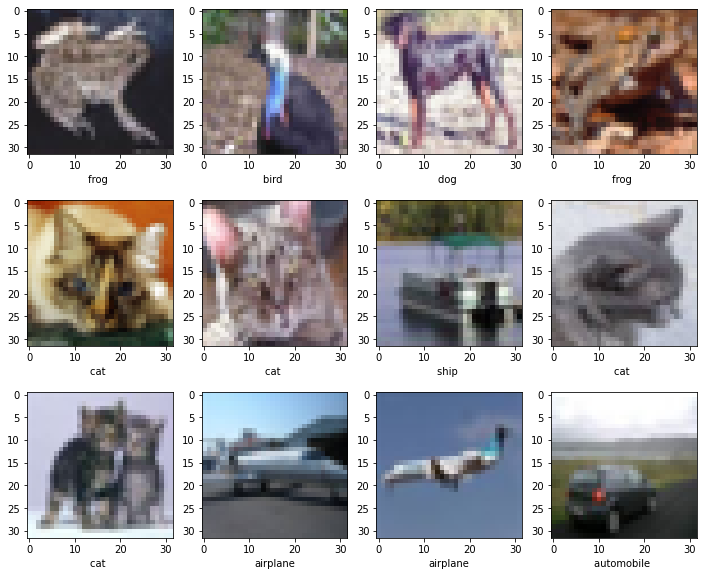

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [5]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [6]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [ ]:
import keras
from keras import layers as L
from keras import backend as K

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
dummy_pred = model.predict(X_train[:20])

assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


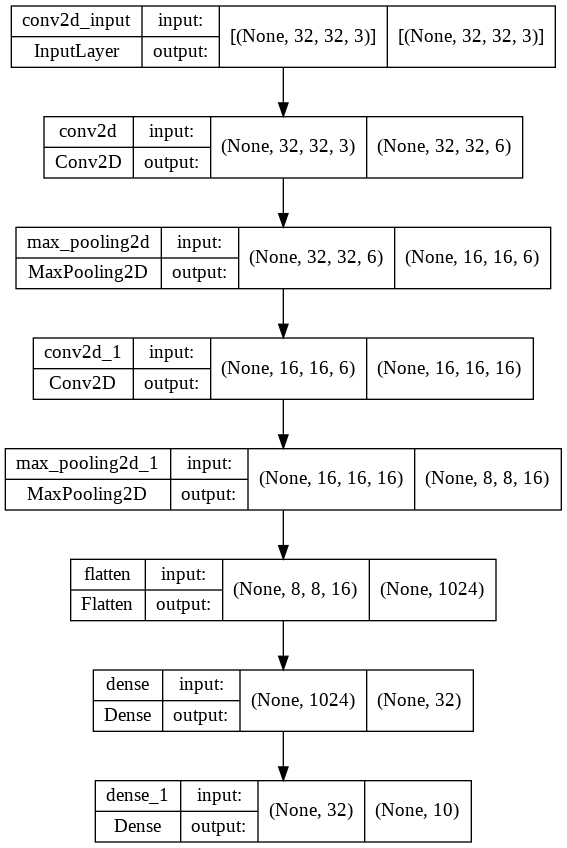

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
y_train, y_val = (tf.keras.utils.to_categorical(y) for y in (y_train, y_val))

In [ ]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/30
1250/1250 [==============================] - 7s 4ms/step - loss: 1.6809 - accuracy: 0.3999 - val_loss: 1.4528 - val_accuracy: 0.4755
Epoch 2/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3622 - accuracy: 0.5199 - val_loss: 1.2909 - val_accuracy: 0.5466
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2473 - accuracy: 0.5616 - val_loss: 1.2386 - val_accuracy: 0.5688
Epoch 4/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1758 - accuracy: 0.5882 - val_loss: 1.1914 - val_accuracy: 0.5769
Epoch 5/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1240 - accuracy: 0.6046 - val_loss: 1.1793 - val_accuracy: 0.5869
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0866 - accuracy: 0.6181 - val_loss: 1.1390 - val_accuracy: 0.6008
Epoch 7/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0545 - accuracy: 0.6319 - val_loss: 1.1314 - val_accuracy:

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test,np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.6178
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
# Your code here

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 1.7199 - accuracy: 0.3840 - val_loss: 1.4511 - val_accuracy: 0.4825
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 1.3729 - accuracy: 0.5142 - val_loss: 1.3218 - val_accuracy: 0.5321
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 1.2553 - accuracy: 0.5566 - val_loss: 1.2548 - val_accuracy: 0.5600
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 1.1886 - accuracy: 0.5827 - val_loss: 1.2014 - val_accuracy: 0.5802
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 1.1402 - accuracy: 0.6007 - val_loss: 1.1819 - val_accuracy: 0.5891
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 1.1005 - accuracy: 0.6125 - val_loss: 1.1638 - val_accuracy: 0.5928
Epoch 7/30
625/625 [==============================] - 3s 5ms/step - loss: 1.0667 - accuracy: 0.6265 - val_loss: 1.1705 - val_accuracy: 0.5877
Epoch 

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")


 Test_acc = 0.5992
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])
        
    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, np.argmax(model.predict(X_test), axis=1))))

In [ ]:
!rm -rf ./logs

In [ ]:
optimizers = {
    'Adadelta': 'Adadelta',
    'Adagrad': 'Adagrad',
    'Adamax': 'Adamax',
    'Ftrl': 'Ftrl',
    'Nadam': 'Nadam',
    'sgd': 'sgd',
    'RMSprop': 'RMSprop',
    'Adam': 'Adam',
}

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

Final score of single_model_Adadelta is 0.4214
Final score of single_model_Adagrad is 0.5102
Final score of single_model_Adamax is 0.5891
Final score of single_model_Ftrl is 0.1
Final score of single_model_Nadam is 0.5619
Final score of single_model_sgd is 0.5973
Final score of single_model_RMSprop is 0.5658
Final score of single_model_Adam is 0.5594


Прокомментируйте полученные результаты:

Оптимизатор SGD показал лучший результат из проверенных

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
# Беру в качестве старта значение метрики из последней модели с лучшим оптимизатором 
# Добавляю нормализацию по батчу - вначале одну нормализацию после разных слоев/сверток, потом комбинирую успешно показавшие себя вставки нормализации по батчу

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 2.0302 - accuracy: 0.2707 - val_loss: 1.8674 - val_accuracy: 0.3416
Epoch 2/30
625/625 [==============================] - 3s 4ms/step - loss: 1.8086 - accuracy: 0.3626 - val_loss: 1.7383 - val_accuracy: 0.3845
Epoch 3/30
625/625 [==============================] - 3s 4ms/step - loss: 1.6809 - accuracy: 0.4106 - val_loss: 1.6232 - val_accuracy: 0.4359
Epoch 4/30
625/625 [==============================] - 3s 4ms/step - loss: 1.5774 - accuracy: 0.4448 - val_loss: 1.5927 - val_accuracy: 0.4344
Epoch 5/30
625/625 [==============================] - 3s 4ms/step - loss: 1.4964 - accuracy: 0.4701 - val_loss: 1.4742 - val_accuracy: 0.4768
Epoch 6/30
625/625 [==============================] - 2s 4ms/step - loss: 1.4342 - accuracy: 0.4917 - val_loss: 1.4692 - val_accuracy: 0.4695
Epoch 7/30
625/625 [==============================] - 2s 4ms/step - loss: 1.3841 - accuracy: 0.5123 - val_loss: 1.3744 - val_accuracy: 0.5096
Epoch 

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)


 Test_acc = 0.5885


In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
# model.add(BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

In [ ]:
from keras.layers.normalization.batch_normalization import BatchNormalization

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=10,
                           kernel_size=(3, 3),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Прокомментируйте полученные результаты.

Все варианты нормализации по батчу показали уменьшение показателя accuracy

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Лучшая из базовых моделей c оптимизатором sgd

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0451 - accuracy: 0.2623 - val_loss: 1.8138 - val_accuracy: 0.3536
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7040 - accuracy: 0.3980 - val_loss: 1.6454 - val_accuracy: 0.4178
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5385 - accuracy: 0.4532 - val_loss: 1.4654 - val_accuracy: 0.4780
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4433 - accuracy: 0.4886 - val_loss: 1.4359 - val_accuracy: 0.4859
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3812 - accuracy: 0.5088 - val_loss: 1.3436 - val_accuracy: 0.5188
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3252 - accuracy: 0.5307 - val_loss: 1.3471 - val_accuracy: 0.5137
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2823 - accuracy: 0.5436 - val_loss: 1.2856 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.5988


Увеличим количество фильтров в свертке 1 слоя до 20

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.9781 - accuracy: 0.2774 - val_loss: 1.7148 - val_accuracy: 0.3798
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6079 - accuracy: 0.4214 - val_loss: 1.5154 - val_accuracy: 0.4508
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4889 - accuracy: 0.4664 - val_loss: 1.4255 - val_accuracy: 0.4917
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4033 - accuracy: 0.5004 - val_loss: 1.3497 - val_accuracy: 0.5194
Epoch 5/15
1250/1250 [==============================] - 6s 4ms/step - loss: 1.3368 - accuracy: 0.5253 - val_loss: 1.3123 - val_accuracy: 0.5340
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2734 - accuracy: 0.5469 - val_loss: 1.2724 - val_accuracy: 0.5495
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2221 - accuracy: 0.5659 - val_loss: 1.2198 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6184


Увеличим размер сверточного ядра до 7 в 1 слое

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9555 - accuracy: 0.2919 - val_loss: 1.8461 - val_accuracy: 0.3411
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6289 - accuracy: 0.4174 - val_loss: 1.5695 - val_accuracy: 0.4427
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4978 - accuracy: 0.4615 - val_loss: 1.5031 - val_accuracy: 0.4582
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4152 - accuracy: 0.4939 - val_loss: 1.3811 - val_accuracy: 0.5068
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3513 - accuracy: 0.5181 - val_loss: 1.3422 - val_accuracy: 0.5203
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2949 - accuracy: 0.5377 - val_loss: 1.3034 - val_accuracy: 0.5367
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2412 - accuracy: 0.5587 - val_loss: 1.2713 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6281


У величим количество входов в первом Dense слое до 64

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9909 - accuracy: 0.2769 - val_loss: 1.7104 - val_accuracy: 0.3909
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6153 - accuracy: 0.4193 - val_loss: 1.5446 - val_accuracy: 0.4409
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4639 - accuracy: 0.4756 - val_loss: 1.5169 - val_accuracy: 0.4594
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3759 - accuracy: 0.5129 - val_loss: 1.3644 - val_accuracy: 0.5102
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3045 - accuracy: 0.5362 - val_loss: 1.2989 - val_accuracy: 0.5297
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2467 - accuracy: 0.5577 - val_loss: 1.2398 - val_accuracy: 0.5548
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1927 - accuracy: 0.5777 - val_loss: 1.2127 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6223


Уменьшим обратно количество входов в первом Dense слое до 32, увеличим размер ядра свертки во втором сверточном слое до 7

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9651 - accuracy: 0.2826 - val_loss: 1.6992 - val_accuracy: 0.3925
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5986 - accuracy: 0.4297 - val_loss: 1.4873 - val_accuracy: 0.4639
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4624 - accuracy: 0.4762 - val_loss: 1.3968 - val_accuracy: 0.5020
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3748 - accuracy: 0.5083 - val_loss: 1.3747 - val_accuracy: 0.5122
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3076 - accuracy: 0.5358 - val_loss: 1.2896 - val_accuracy: 0.5398
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2566 - accuracy: 0.5541 - val_loss: 1.2796 - val_accuracy: 0.5424
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2069 - accuracy: 0.5713 - val_loss: 1.2233 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6328


увеличим размер ядра свертки во втором сверточном слое до 9

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(9, 9),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=15,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0022 - accuracy: 0.2673 - val_loss: 1.7769 - val_accuracy: 0.3434
Epoch 2/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6377 - accuracy: 0.4085 - val_loss: 1.5390 - val_accuracy: 0.4499
Epoch 3/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4854 - accuracy: 0.4662 - val_loss: 1.5093 - val_accuracy: 0.4585
Epoch 4/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3891 - accuracy: 0.5026 - val_loss: 1.3477 - val_accuracy: 0.5194
Epoch 5/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3133 - accuracy: 0.5345 - val_loss: 1.3073 - val_accuracy: 0.5368
Epoch 6/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2546 - accuracy: 0.5544 - val_loss: 1.2567 - val_accuracy: 0.5567
Epoch 7/15
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1971 - accuracy: 0.5771 - val_loss: 1.2060 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6236


Вернем размер свертки ядра свертки до 7 во втором слое, увеличим количество эпох в 2 раза

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=30,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/30
1250/1250 [==============================] - 6s 4ms/step - loss: 1.9648 - accuracy: 0.2901 - val_loss: 1.7120 - val_accuracy: 0.3922
Epoch 2/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6339 - accuracy: 0.4145 - val_loss: 1.5444 - val_accuracy: 0.4383
Epoch 3/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4869 - accuracy: 0.4653 - val_loss: 1.4353 - val_accuracy: 0.4841
Epoch 4/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4031 - accuracy: 0.4966 - val_loss: 1.3427 - val_accuracy: 0.5168
Epoch 5/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3294 - accuracy: 0.5251 - val_loss: 1.3587 - val_accuracy: 0.5135
Epoch 6/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2711 - accuracy: 0.5459 - val_loss: 1.2993 - val_accuracy: 0.5379
Epoch 7/30
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2218 - accuracy: 0.5657 - val_loss: 1.2040 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6638


Увеличим количество эпох в 2 раза

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0119 - accuracy: 0.2649 - val_loss: 1.7655 - val_accuracy: 0.3644
Epoch 2/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6328 - accuracy: 0.4143 - val_loss: 1.5115 - val_accuracy: 0.4542
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4834 - accuracy: 0.4654 - val_loss: 1.4567 - val_accuracy: 0.4743
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3953 - accuracy: 0.4980 - val_loss: 1.4283 - val_accuracy: 0.4856
Epoch 5/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3260 - accuracy: 0.5256 - val_loss: 1.2821 - val_accuracy: 0.5447
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2723 - accuracy: 0.5468 - val_loss: 1.2691 - val_accuracy: 0.5516
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2243 - accuracy: 0.5644 - val_loss: 1.2274 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6161


Добавим Dropout в 20 % после первого слоя

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0331 - accuracy: 0.2543 - val_loss: 1.8959 - val_accuracy: 0.2975
Epoch 2/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7263 - accuracy: 0.3791 - val_loss: 1.6362 - val_accuracy: 0.4129
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5547 - accuracy: 0.4429 - val_loss: 1.4925 - val_accuracy: 0.4606
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4580 - accuracy: 0.4755 - val_loss: 1.3954 - val_accuracy: 0.5040
Epoch 5/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3869 - accuracy: 0.5029 - val_loss: 1.3522 - val_accuracy: 0.5176
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3283 - accuracy: 0.5265 - val_loss: 1.2900 - val_accuracy: 0.5426
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2748 - accuracy: 0.5461 - val_loss: 1.2464 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6687


Добавим после вторго слоя dropout в 20%

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0442 - accuracy: 0.2491 - val_loss: 1.8243 - val_accuracy: 0.3451
Epoch 2/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7064 - accuracy: 0.3837 - val_loss: 1.5946 - val_accuracy: 0.4304
Epoch 3/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5704 - accuracy: 0.4354 - val_loss: 1.5102 - val_accuracy: 0.4573
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4761 - accuracy: 0.4696 - val_loss: 1.4302 - val_accuracy: 0.4847
Epoch 5/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.4119 - accuracy: 0.4958 - val_loss: 1.3735 - val_accuracy: 0.5202
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3522 - accuracy: 0.5160 - val_loss: 1.2901 - val_accuracy: 0.5405
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3046 - accuracy: 0.5350 - val_loss: 1.2681 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7049


Добавим после Dense слоя dropout в 20%

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0941 - accuracy: 0.2142 - val_loss: 1.8425 - val_accuracy: 0.3372
Epoch 2/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.8073 - accuracy: 0.3374 - val_loss: 1.6047 - val_accuracy: 0.4309
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6629 - accuracy: 0.3945 - val_loss: 1.5102 - val_accuracy: 0.4487
Epoch 4/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5780 - accuracy: 0.4254 - val_loss: 1.4366 - val_accuracy: 0.4853
Epoch 5/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5208 - accuracy: 0.4454 - val_loss: 1.3844 - val_accuracy: 0.4975
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4710 - accuracy: 0.4649 - val_loss: 1.3662 - val_accuracy: 0.5189
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4352 - accuracy: 0.4802 - val_loss: 1.3091 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6917


Отменим последнее добавление дропаута, изменим архитектуру сети в соответствии с

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035 

https://habr.com/ru/post/498168/ 

Densely Connected CNN (DenseNet)

https://github.com/Machine-Learning-Tokyo/DL-workshop-series/blob/master/Part%20I%20-%20Convolution%20Operations/ConvNets.ipynb 

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [ ]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  
  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
n_classes = 10
img_shape = (32, 32, 3)
model = densenet(img_shape, n_classes=10, f=32)

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 89s 62ms/step - loss: 1.6688 - accuracy: 0.3880 - val_loss: 1.6214 - val_accuracy: 0.4025
Epoch 2/60
1250/1250 [==============================] - 72s 58ms/step - loss: 1.3386 - accuracy: 0.5140 - val_loss: 1.3910 - val_accuracy: 0.4968
Epoch 3/60
1250/1250 [==============================] - 73s 58ms/step - loss: 1.1569 - accuracy: 0.5845 - val_loss: 1.2083 - val_accuracy: 0.5675
Epoch 4/60
1250/1250 [==============================] - 70s 56ms/step - loss: 1.0188 - accuracy: 0.6367 - val_loss: 1.2394 - val_accuracy: 0.5645
Epoch 5/60
1250/1250 [==============================] - 72s 57ms/step - loss: 0.9124 - accuracy: 0.6749 - val_loss: 1.2793 - val_accuracy: 0.5445
Epoch 6/60
1250/1250 [==============================] - 68s 55ms/step - loss: 0.8165 - accuracy: 0.7109 - val_loss: 1.2102 - val_accuracy: 0.5807
Epoch 7/60
1250/1250 [==============================] - 69s 55ms/step - loss: 0.7289 - accuracy: 0.7426 - val_loss: 1.0807 -

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7085


Убирать количество эпох не будум, добавим dropout 20%

In [ ]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    tf.keras.layers.Dropout(0.2)##
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  tf.keras.layers.Dropout(0.2)##

  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
n_classes = 10
img_shape = (32, 32, 3)
model = densenet(img_shape, n_classes=10, f=32)

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 90s 65ms/step - loss: 1.6620 - accuracy: 0.3897 - val_loss: 1.5205 - val_accuracy: 0.4442
Epoch 2/60
1250/1250 [==============================] - 78s 62ms/step - loss: 1.3336 - accuracy: 0.5176 - val_loss: 1.4314 - val_accuracy: 0.4946
Epoch 3/60
1250/1250 [==============================] - 81s 65ms/step - loss: 1.1625 - accuracy: 0.5827 - val_loss: 1.1827 - val_accuracy: 0.5704
Epoch 4/60
1250/1250 [==============================] - 74s 59ms/step - loss: 1.0302 - accuracy: 0.6341 - val_loss: 1.7298 - val_accuracy: 0.4384
Epoch 5/60
1250/1250 [==============================] - 72s 57ms/step - loss: 0.9216 - accuracy: 0.6732 - val_loss: 1.0409 - val_accuracy: 0.6285
Epoch 6/60
1250/1250 [==============================] - 73s 59ms/step - loss: 0.8273 - accuracy: 0.7085 - val_loss: 1.2403 - val_accuracy: 0.5743
Epoch 7/60
1250/1250 [==============================] - 73s 59ms/step - loss: 0.7377 - accuracy: 0.7395 - val_loss: 1.3359 -

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7068


Увеличим количество фильтров в сверточных слоях в 2 раза

In [ ]:
def densenet(img_shape, n_classes, f=32):
  repetitions = 6, 12, 24, 16
  
  def bn_rl_conv(x, f, k=1, s=1, p='same'):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(f, k, strides=s, padding=p)(x)
    return x
  
  
  def dense_block(tensor, r):
    for _ in range(r):
      x = bn_rl_conv(tensor, 4*f)
      x = bn_rl_conv(x, f, 3)
      tensor = Concatenate()([tensor, x])
    return tensor
  
  
  def transition_block(x):
    x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    return x
  
  
  input = Input(img_shape)
  
  x = Conv2D(64, 7, strides=2, padding='same')(input)
  x = MaxPool2D(3, strides=2, padding='same')(x)
  x = Dropout(0.5)(x)  #

  for r in repetitions:
    d = dense_block(x, r)
    x = transition_block(d)
  
  x = GlobalAvgPool2D()(d)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [ ]:
n_classes = 10
img_shape = 32, 32, 3
model = densenet(img_shape, n_classes, f=64)

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs = 30
history = model.fit(X_train, 
                    y_train,
                    batch_size=32, 
                    epochs=epochs,
                    validation_data=[X_val, y_val],
                    callbacks=callbacks,
                    )

Epoch 1/30
1250/1250 [==============================] - 118s 79ms/step - loss: 1.8067 - accuracy: 0.3344 - val_loss: 1.8642 - val_accuracy: 0.3141
Epoch 2/30
1250/1250 [==============================] - 97s 78ms/step - loss: 1.4839 - accuracy: 0.4564 - val_loss: 1.9262 - val_accuracy: 0.3642
Epoch 3/30
1250/1250 [==============================] - 96s 77ms/step - loss: 1.3247 - accuracy: 0.5205 - val_loss: 2.0903 - val_accuracy: 0.3177
Epoch 4/30
1250/1250 [==============================] - 100s 80ms/step - loss: 1.2136 - accuracy: 0.5647 - val_loss: 1.8107 - val_accuracy: 0.4052
Epoch 5/30
1250/1250 [==============================] - 97s 77ms/step - loss: 1.1147 - accuracy: 0.5998 - val_loss: 1.3808 - val_accuracy: 0.5084
Epoch 6/30
1250/1250 [==============================] - 97s 77ms/step - loss: 1.0270 - accuracy: 0.6331 - val_loss: 1.5890 - val_accuracy: 0.4917
Epoch 7/30
1250/1250 [==============================] - 96s 77ms/step - loss: 0.9392 - accuracy: 0.6647 - val_loss: 1.2202

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6799


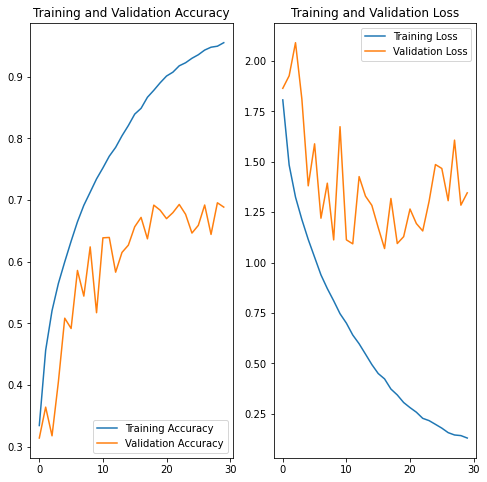

In [ ]:
# https://www.tensorflow.org/tutorials/images/classification

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Вернемся к своей неронной сети и увеличим dropout до 40%

In [ ]:
model = tf.keras.models.Sequential([                              
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1444 - accuracy: 0.5935 - val_loss: 1.0889 - val_accuracy: 0.6140
Epoch 2/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1352 - accuracy: 0.5957 - val_loss: 1.0827 - val_accuracy: 0.6122
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1226 - accuracy: 0.6000 - val_loss: 1.0536 - val_accuracy: 0.6349
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1195 - accuracy: 0.6044 - val_loss: 1.0366 - val_accuracy: 0.6434
Epoch 5/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1080 - accuracy: 0.6070 - val_loss: 1.0485 - val_accuracy: 0.6439
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1006 - accuracy: 0.6106 - val_loss: 1.0317 - val_accuracy: 0.6402
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0953 - accuracy: 0.6143 - val_loss: 1.0236 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6963


Увеличим количество входов Dense слоя до 64

In [ ]:
model = tf.keras.models.Sequential([                              
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0624 - accuracy: 0.2348 - val_loss: 1.8093 - val_accuracy: 0.3586
Epoch 2/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7628 - accuracy: 0.3587 - val_loss: 1.6112 - val_accuracy: 0.4118
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6183 - accuracy: 0.4126 - val_loss: 1.5198 - val_accuracy: 0.4588
Epoch 4/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5346 - accuracy: 0.4456 - val_loss: 1.4471 - val_accuracy: 0.4814
Epoch 5/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.4805 - accuracy: 0.4645 - val_loss: 1.3747 - val_accuracy: 0.5131
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4345 - accuracy: 0.4848 - val_loss: 1.3488 - val_accuracy: 0.5265
Epoch 7/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.3995 - accuracy: 0.4970 - val_loss: 1.3060 - val_accuracy:

Увеличим количество входов Dense слоя до 128

In [ ]:
model = tf.keras.models.Sequential([                              
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0599 - accuracy: 0.2356 - val_loss: 1.7942 - val_accuracy: 0.3663
Epoch 2/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.7324 - accuracy: 0.3681 - val_loss: 1.5884 - val_accuracy: 0.4319
Epoch 3/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5877 - accuracy: 0.4212 - val_loss: 1.4782 - val_accuracy: 0.4771
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5072 - accuracy: 0.4523 - val_loss: 1.4528 - val_accuracy: 0.4818
Epoch 5/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4466 - accuracy: 0.4772 - val_loss: 1.3628 - val_accuracy: 0.5298
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4011 - accuracy: 0.4981 - val_loss: 1.3064 - val_accuracy: 0.5341
Epoch 7/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.3540 - accuracy: 0.5145 - val_loss: 1.2652 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7214


Увеличим количество входов Dense слоя до 156

In [ ]:
model = tf.keras.models.Sequential([                              
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 6s 4ms/step - loss: 2.0312 - accuracy: 0.2433 - val_loss: 1.7300 - val_accuracy: 0.3862
Epoch 2/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6983 - accuracy: 0.3791 - val_loss: 1.5724 - val_accuracy: 0.4314
Epoch 3/60
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5675 - accuracy: 0.4320 - val_loss: 1.4529 - val_accuracy: 0.4878
Epoch 4/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4930 - accuracy: 0.4597 - val_loss: 1.4267 - val_accuracy: 0.4870
Epoch 5/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4394 - accuracy: 0.4823 - val_loss: 1.3557 - val_accuracy: 0.5242
Epoch 6/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3886 - accuracy: 0.5016 - val_loss: 1.3152 - val_accuracy: 0.5320
Epoch 7/60
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3472 - accuracy: 0.5156 - val_loss: 1.2835 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7225


Увеличим количество входов Dense слоя до 256

In [ ]:
model = tf.keras.models.Sequential([                              
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 2.0233 - accuracy: 0.2519 - val_loss: 1.7613 - val_accuracy: 0.3686
Epoch 2/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.7313 - accuracy: 0.3727 - val_loss: 1.5763 - val_accuracy: 0.4290
Epoch 3/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.5991 - accuracy: 0.4193 - val_loss: 1.5140 - val_accuracy: 0.4619
Epoch 4/60
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5063 - accuracy: 0.4530 - val_loss: 1.4455 - val_accuracy: 0.4829
Epoch 5/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.4484 - accuracy: 0.4767 - val_loss: 1.3464 - val_accuracy: 0.5291
Epoch 6/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.4029 - accuracy: 0.4954 - val_loss: 1.3195 - val_accuracy: 0.5268
Epoch 7/60
1250/1250 [==============================] - 6s 4ms/step - loss: 1.3608 - accuracy: 0.5095 - val_loss: 1.2746 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7204


Вернемся к 156 входам

Добавим аугментацию

layers.RandomFlip("horizontal_and_vertical")

In [ ]:
model = tf.keras.models.Sequential([  
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                        
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=32, 
          epochs=60,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/60
1250/1250 [==============================] - 7s 5ms/step - loss: 2.1384 - accuracy: 0.1973 - val_loss: 1.9702 - val_accuracy: 0.2879
Epoch 2/60
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8687 - accuracy: 0.3090 - val_loss: 1.7251 - val_accuracy: 0.3803
Epoch 3/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7215 - accuracy: 0.3664 - val_loss: 1.6769 - val_accuracy: 0.3992
Epoch 4/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6512 - accuracy: 0.3943 - val_loss: 1.5952 - val_accuracy: 0.4247
Epoch 5/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5961 - accuracy: 0.4162 - val_loss: 1.5198 - val_accuracy: 0.4641
Epoch 6/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5570 - accuracy: 0.4313 - val_loss: 1.4922 - val_accuracy: 0.4611
Epoch 7/60
1250/1250 [==============================] - 6s 5ms/step - loss: 1.5316 - accuracy: 0.4411 - val_loss: 1.4329 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6649


Добавим количество эпох

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=90,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/90
625/625 [==============================] - 8s 10ms/step - loss: 0.9036 - accuracy: 0.6794 - val_loss: 0.8620 - val_accuracy: 0.7015
Epoch 2/90
625/625 [==============================] - 5s 8ms/step - loss: 0.8947 - accuracy: 0.6801 - val_loss: 0.8512 - val_accuracy: 0.7041
Epoch 3/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8972 - accuracy: 0.6823 - val_loss: 0.8443 - val_accuracy: 0.7042
Epoch 4/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8893 - accuracy: 0.6814 - val_loss: 0.8454 - val_accuracy: 0.7022
Epoch 5/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8878 - accuracy: 0.6825 - val_loss: 0.8394 - val_accuracy: 0.7085
Epoch 6/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8904 - accuracy: 0.6842 - val_loss: 0.8513 - val_accuracy: 0.7001
Epoch 7/90
625/625 [==============================] - 3s 6ms/step - loss: 0.8874 - accuracy: 0.6864 - val_loss: 0.8419 - val_accuracy: 0.7035
Epoch

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7065


Добавим аугментацию

tf.keras.layers.RandomRotation(0.2)

In [ ]:
model = tf.keras.models.Sequential([  
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
                        
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=90,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/90
625/625 [==============================] - 6s 7ms/step - loss: 2.1855 - accuracy: 0.1746 - val_loss: 2.0662 - val_accuracy: 0.2384
Epoch 2/90
625/625 [==============================] - 4s 6ms/step - loss: 2.0387 - accuracy: 0.2444 - val_loss: 1.9532 - val_accuracy: 0.2902
Epoch 3/90
625/625 [==============================] - 3s 5ms/step - loss: 1.9615 - accuracy: 0.2794 - val_loss: 1.8647 - val_accuracy: 0.3345
Epoch 4/90
625/625 [==============================] - 4s 6ms/step - loss: 1.9032 - accuracy: 0.3103 - val_loss: 1.8179 - val_accuracy: 0.3619
Epoch 5/90
625/625 [==============================] - 3s 6ms/step - loss: 1.8625 - accuracy: 0.3270 - val_loss: 1.7739 - val_accuracy: 0.3724
Epoch 6/90
625/625 [==============================] - 4s 6ms/step - loss: 1.8334 - accuracy: 0.3370 - val_loss: 1.7580 - val_accuracy: 0.3772
Epoch 7/90
625/625 [==============================] - 4s 6ms/step - loss: 1.8096 - accuracy: 0.3460 - val_loss: 1.7184 - val_accuracy: 0.3817
Epoch 

Убираем RandomRotation и добавим Dense слой

In [ ]:
model = tf.keras.models.Sequential([  
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
                        
    tf.keras.layers.Conv2D(filters=20,
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu',
                           input_shape=X_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),
    
    tf.keras.layers.Conv2D(filters=20, 
                           kernel_size=(7, 7),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dense(156, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [ ]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, 
          y_train,
          batch_size=64, 
          epochs=90,
          validation_data=[X_val, y_val],
          callbacks=callbacks,
          )

Epoch 1/90
625/625 [==============================] - 87s 139ms/step - loss: 2.2197 - accuracy: 0.1555 - val_loss: 2.0944 - val_accuracy: 0.2122
Epoch 2/90
625/625 [==============================] - 89s 142ms/step - loss: 2.0593 - accuracy: 0.2308 - val_loss: 1.9653 - val_accuracy: 0.2710
Epoch 3/90
625/625 [==============================] - 88s 141ms/step - loss: 1.9214 - accuracy: 0.2884 - val_loss: 1.8035 - val_accuracy: 0.3483
Epoch 4/90
625/625 [==============================] - 88s 141ms/step - loss: 1.8120 - accuracy: 0.3331 - val_loss: 1.7095 - val_accuracy: 0.3882
Epoch 5/90
625/625 [==============================] - 87s 140ms/step - loss: 1.7367 - accuracy: 0.3616 - val_loss: 1.7167 - val_accuracy: 0.3808
Epoch 6/90
625/625 [==============================] - 88s 140ms/step - loss: 1.6925 - accuracy: 0.3779 - val_loss: 1.6167 - val_accuracy: 0.4195
Epoch 7/90
625/625 [==============================] - 88s 140ms/step - loss: 1.6485 - accuracy: 0.3950 - val_loss: 1.5788 - val_ac

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.6546


Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
from sklearn.metrics import accuracy_score
test_acc = accuracy_score(y_test, np.argmax(model.predict(X_test),axis=1))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")


 Test_acc = 0.7204


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

**The struggle is real**

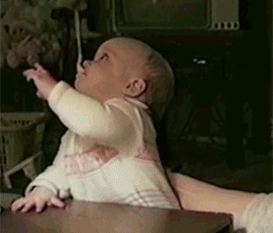